In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# COSC 757 Assignment 1
Working with the Algerian Forest Fires Dataset: https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++


In [3]:
#Split CSV into two datasets based on region
bejaia_df = pd.read_csv("bejaia_fire.csv",skiprows=1)
sidibel_df = pd.read_csv("sidibel_fire.csv",skiprows=1)

#Merge them into one dataset with an additional region column
bejaia_df['Region'] = 'Bejaia'
sidibel_df['Region'] = 'Sidi-Bel Abbes'

fire_df = pd.concat([bejaia_df,sidibel_df],ignore_index=True)
fire_df.columns = fire_df.columns.str.strip()
fire_df['Classes'] = fire_df['Classes'].str.strip()
fire_df = fire_df.astype({'DC':'float64','FWI':'float64','Classes':'category','Region':'category'})

## Exploratory Data Analysis

In [4]:
fire_df.columns
#fire_df.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

In [5]:
fire_df['Classes'].unique()


['not fire', 'fire']
Categories (2, object): ['fire', 'not fire']

No handles with labels found to put in legend.
No handles with labels found to put in legend.


         Column         Mean   Median Standard Deviation   Min    Max
0           day    15.754098    16.00           8.806957     1     31
1         month     7.500000     7.50           1.110678     6      9
2          year  2012.000000  2012.00           0.000000  2012   2012
3   Temperature    32.172131    32.00           3.626389    22     42
4            RH    61.938525    63.00          14.853668    21     90
5            Ws    15.504098    15.00           2.804414     6     29
6          Rain     0.760656     0.00           1.995304   0.0   16.8
7          FFMC    77.887705    83.50          14.308160  28.6   96.0
8           DMC    14.673361    11.30          12.342668   0.7   65.9
9            DC    49.288115    33.10          47.521981   6.9  220.4
10          ISI     4.759836     3.50           4.146105   0.0   19.0
11          BUI    16.673361    12.45          14.172517   1.1   68.0
12          FWI     7.049180     4.45           7.413128   0.0   31.1


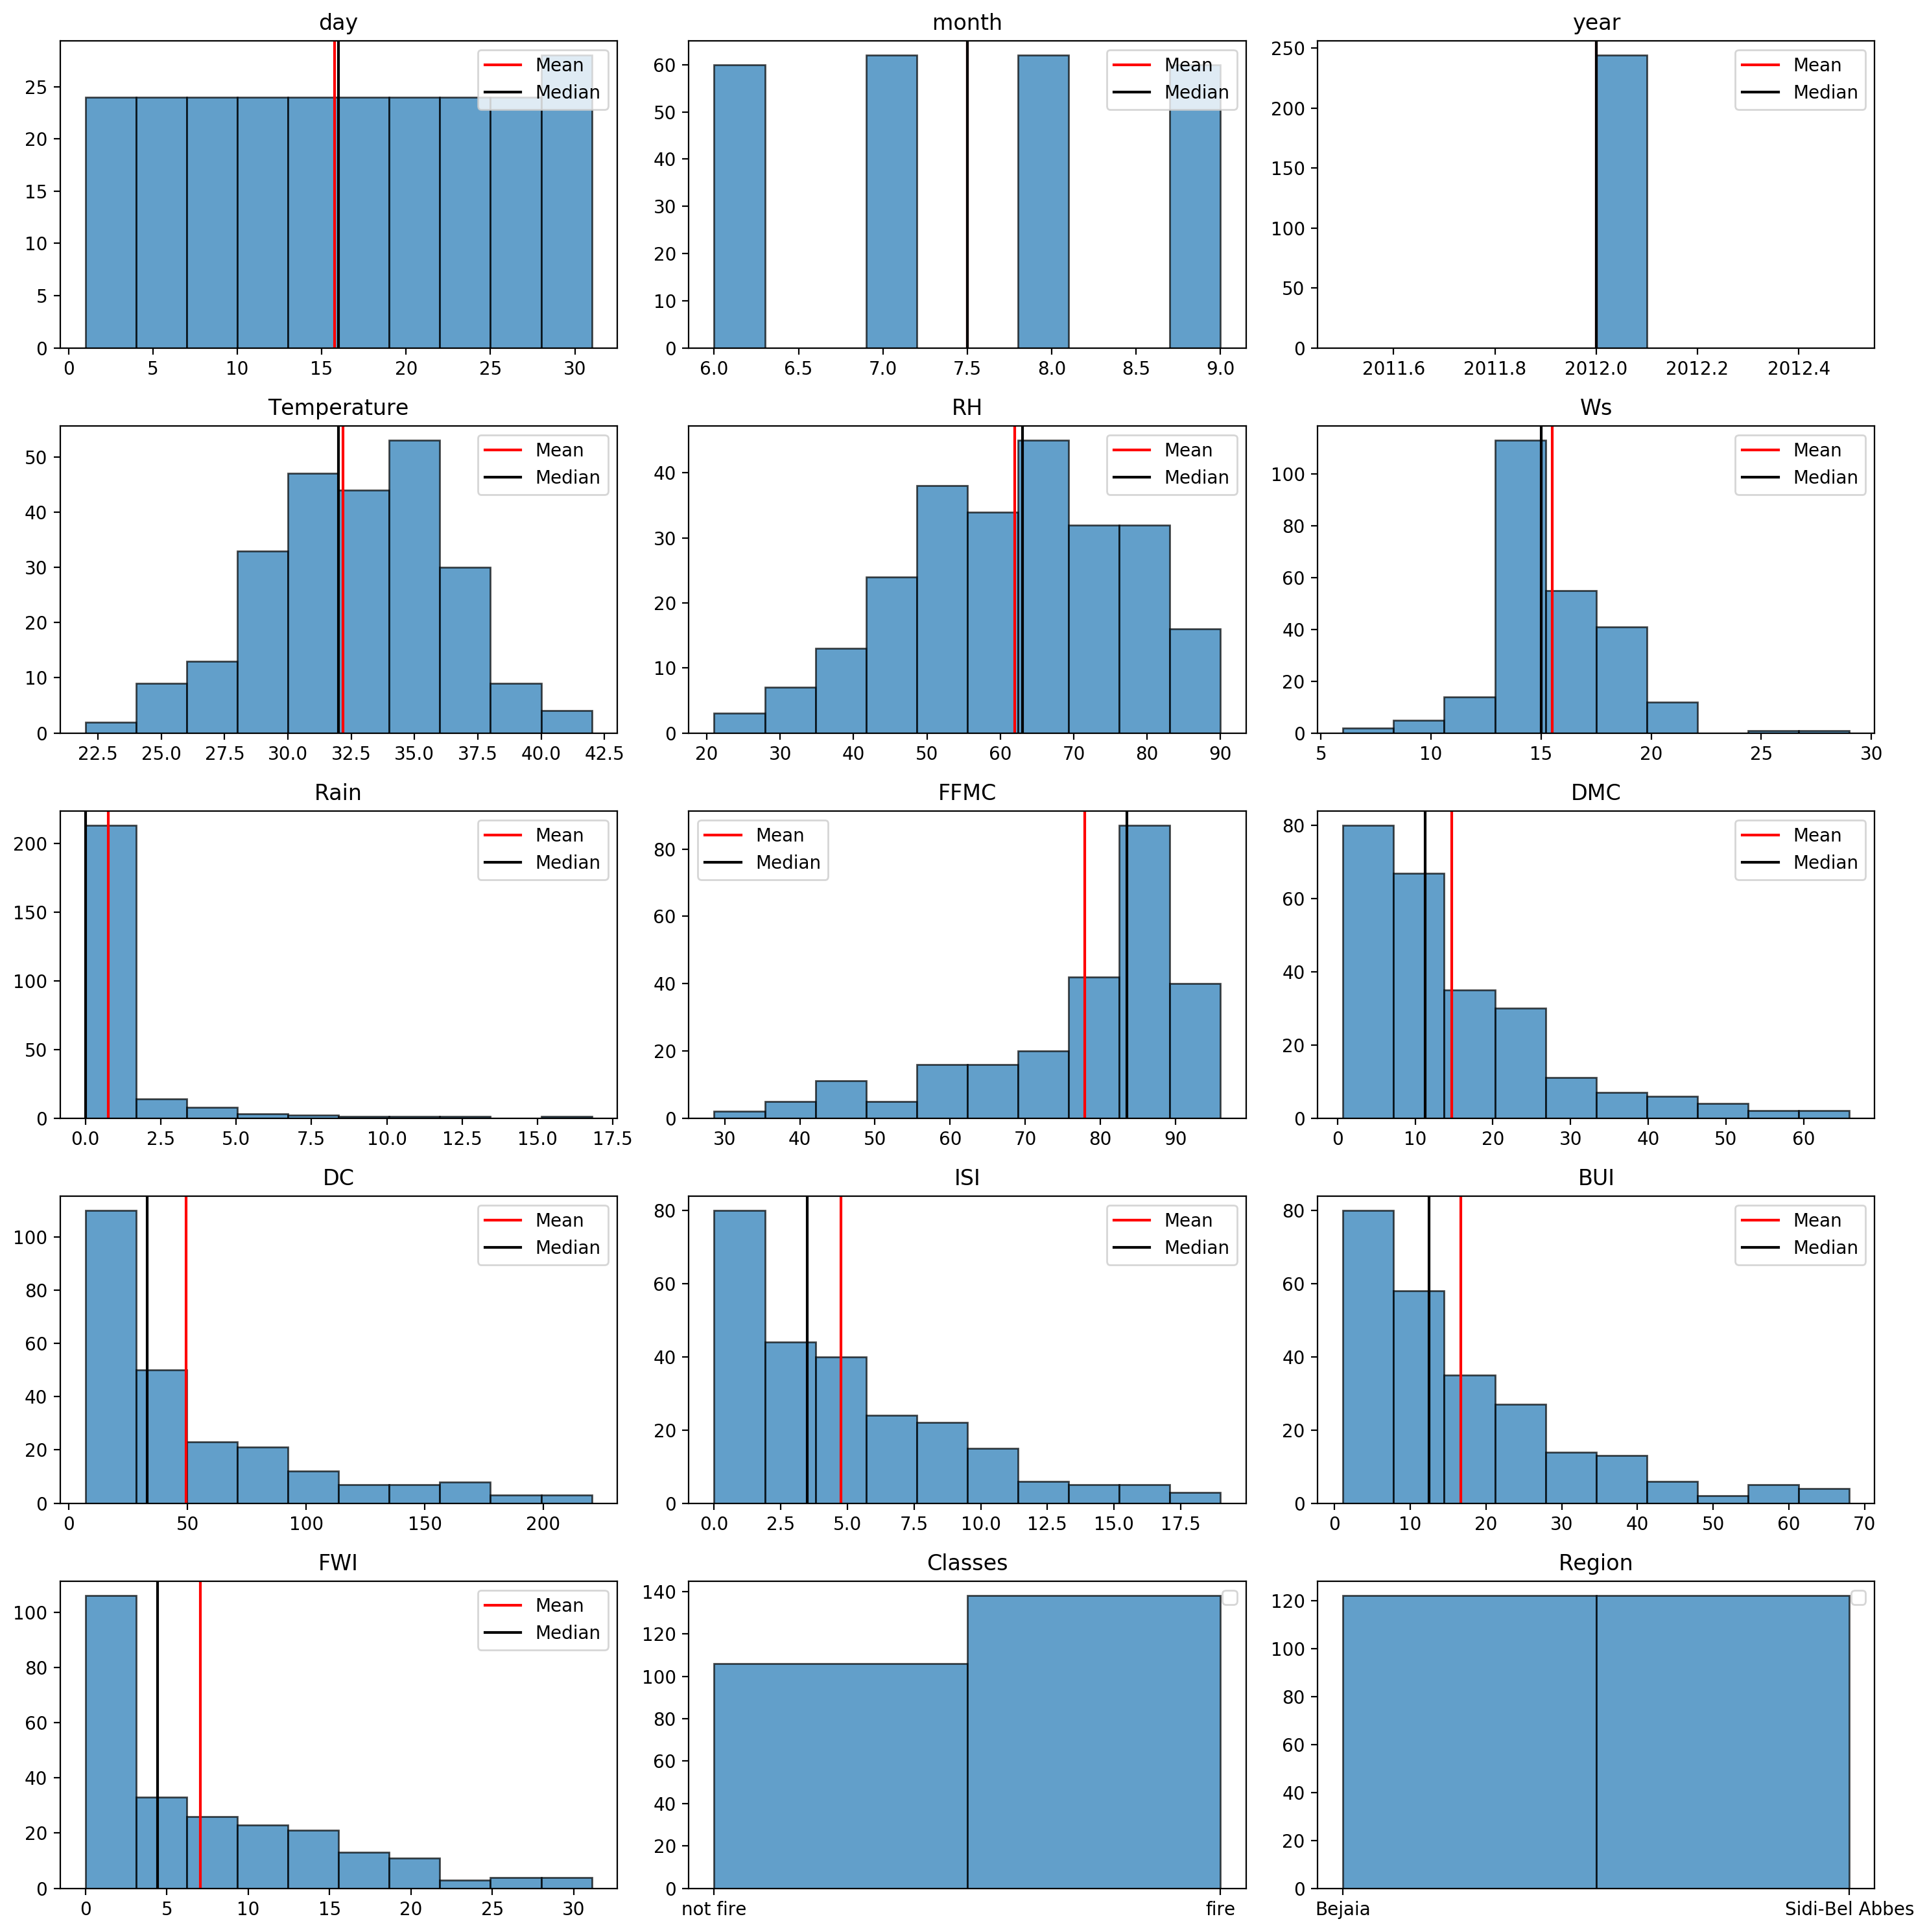

In [31]:
cols = np.array(fire_df.columns)
count=0

col_df = pd.DataFrame(columns=[['Column','Mean','Median', 'Standard Deviation', 'Min', 'Max']])

fig, ax = plt.subplots(5,3,figsize=(15,15),dpi=200)
for i,col in enumerate(ax):
    for j, row in enumerate(col):
        try:
            feature = fire_df[cols[count]]
            feature_arr = np.array(feature)
            #print(cols[count],np.mean(feature_arr))
            if (feature.dtype=='int64') or (feature.dtype=='float64'):
                col_df.loc[len(col_df.index)] = [cols[count], np.mean(feature_arr),np.median(feature_arr),np.std(feature_arr),min(feature_arr),max(feature_arr)]
            ax[i,j].set_title(cols[count])
            if feature.dtype.name == 'category':
                ax[i,j].hist(feature_arr,bins=len(feature.unique()),ec='k',alpha=0.7)
                
            else:
                ax[i,j].hist(feature_arr,ec='k',alpha=0.7)
                ax[i,j].axvline(np.mean(feature_arr),label='Mean',color='r')
                ax[i,j].axvline(np.median(feature_arr),label='Median',color='k')
            ax[i,j].legend()
            count+=1
        except IndexError:
            pass

plt.tight_layout()
print(col_df)


In [19]:
col_df

,Column,Mean,Median,Standard Deviation,Min,Max
0,day,15.754098,16.00,8.806957,1,31
1,month,7.500000,7.50,1.110678,6,9
2,year,2012.000000,2012.00,0.000000,2012,2012
3,Temperature,32.172131,32.00,3.626389,22,42
4,RH,61.938525,63.00,14.853668,21,90
5,Ws,15.504098,15.00,2.804414,6,29
6,Rain,0.760656,0.00,1.995304,0.0,16.8
7,FFMC,77.887705,83.50,14.308160,28.6,96.0
8,DMC,14.673361,11.30,12.342668,0.7,65.9
9,DC,49.288115,33.10,47.521981,6.9,220.4


### Fire Classification Feature Relationships

In [34]:
# Explore Fire Classification vs Variables

#Turn Fire Classification into a Flag Variable
fire_int = []
for fireclass in fire_df['Classes']:
    if fireclass == "not fire":
        fire_int.append(0)
    elif fireclass == "fire":
        fire_int.append(1)





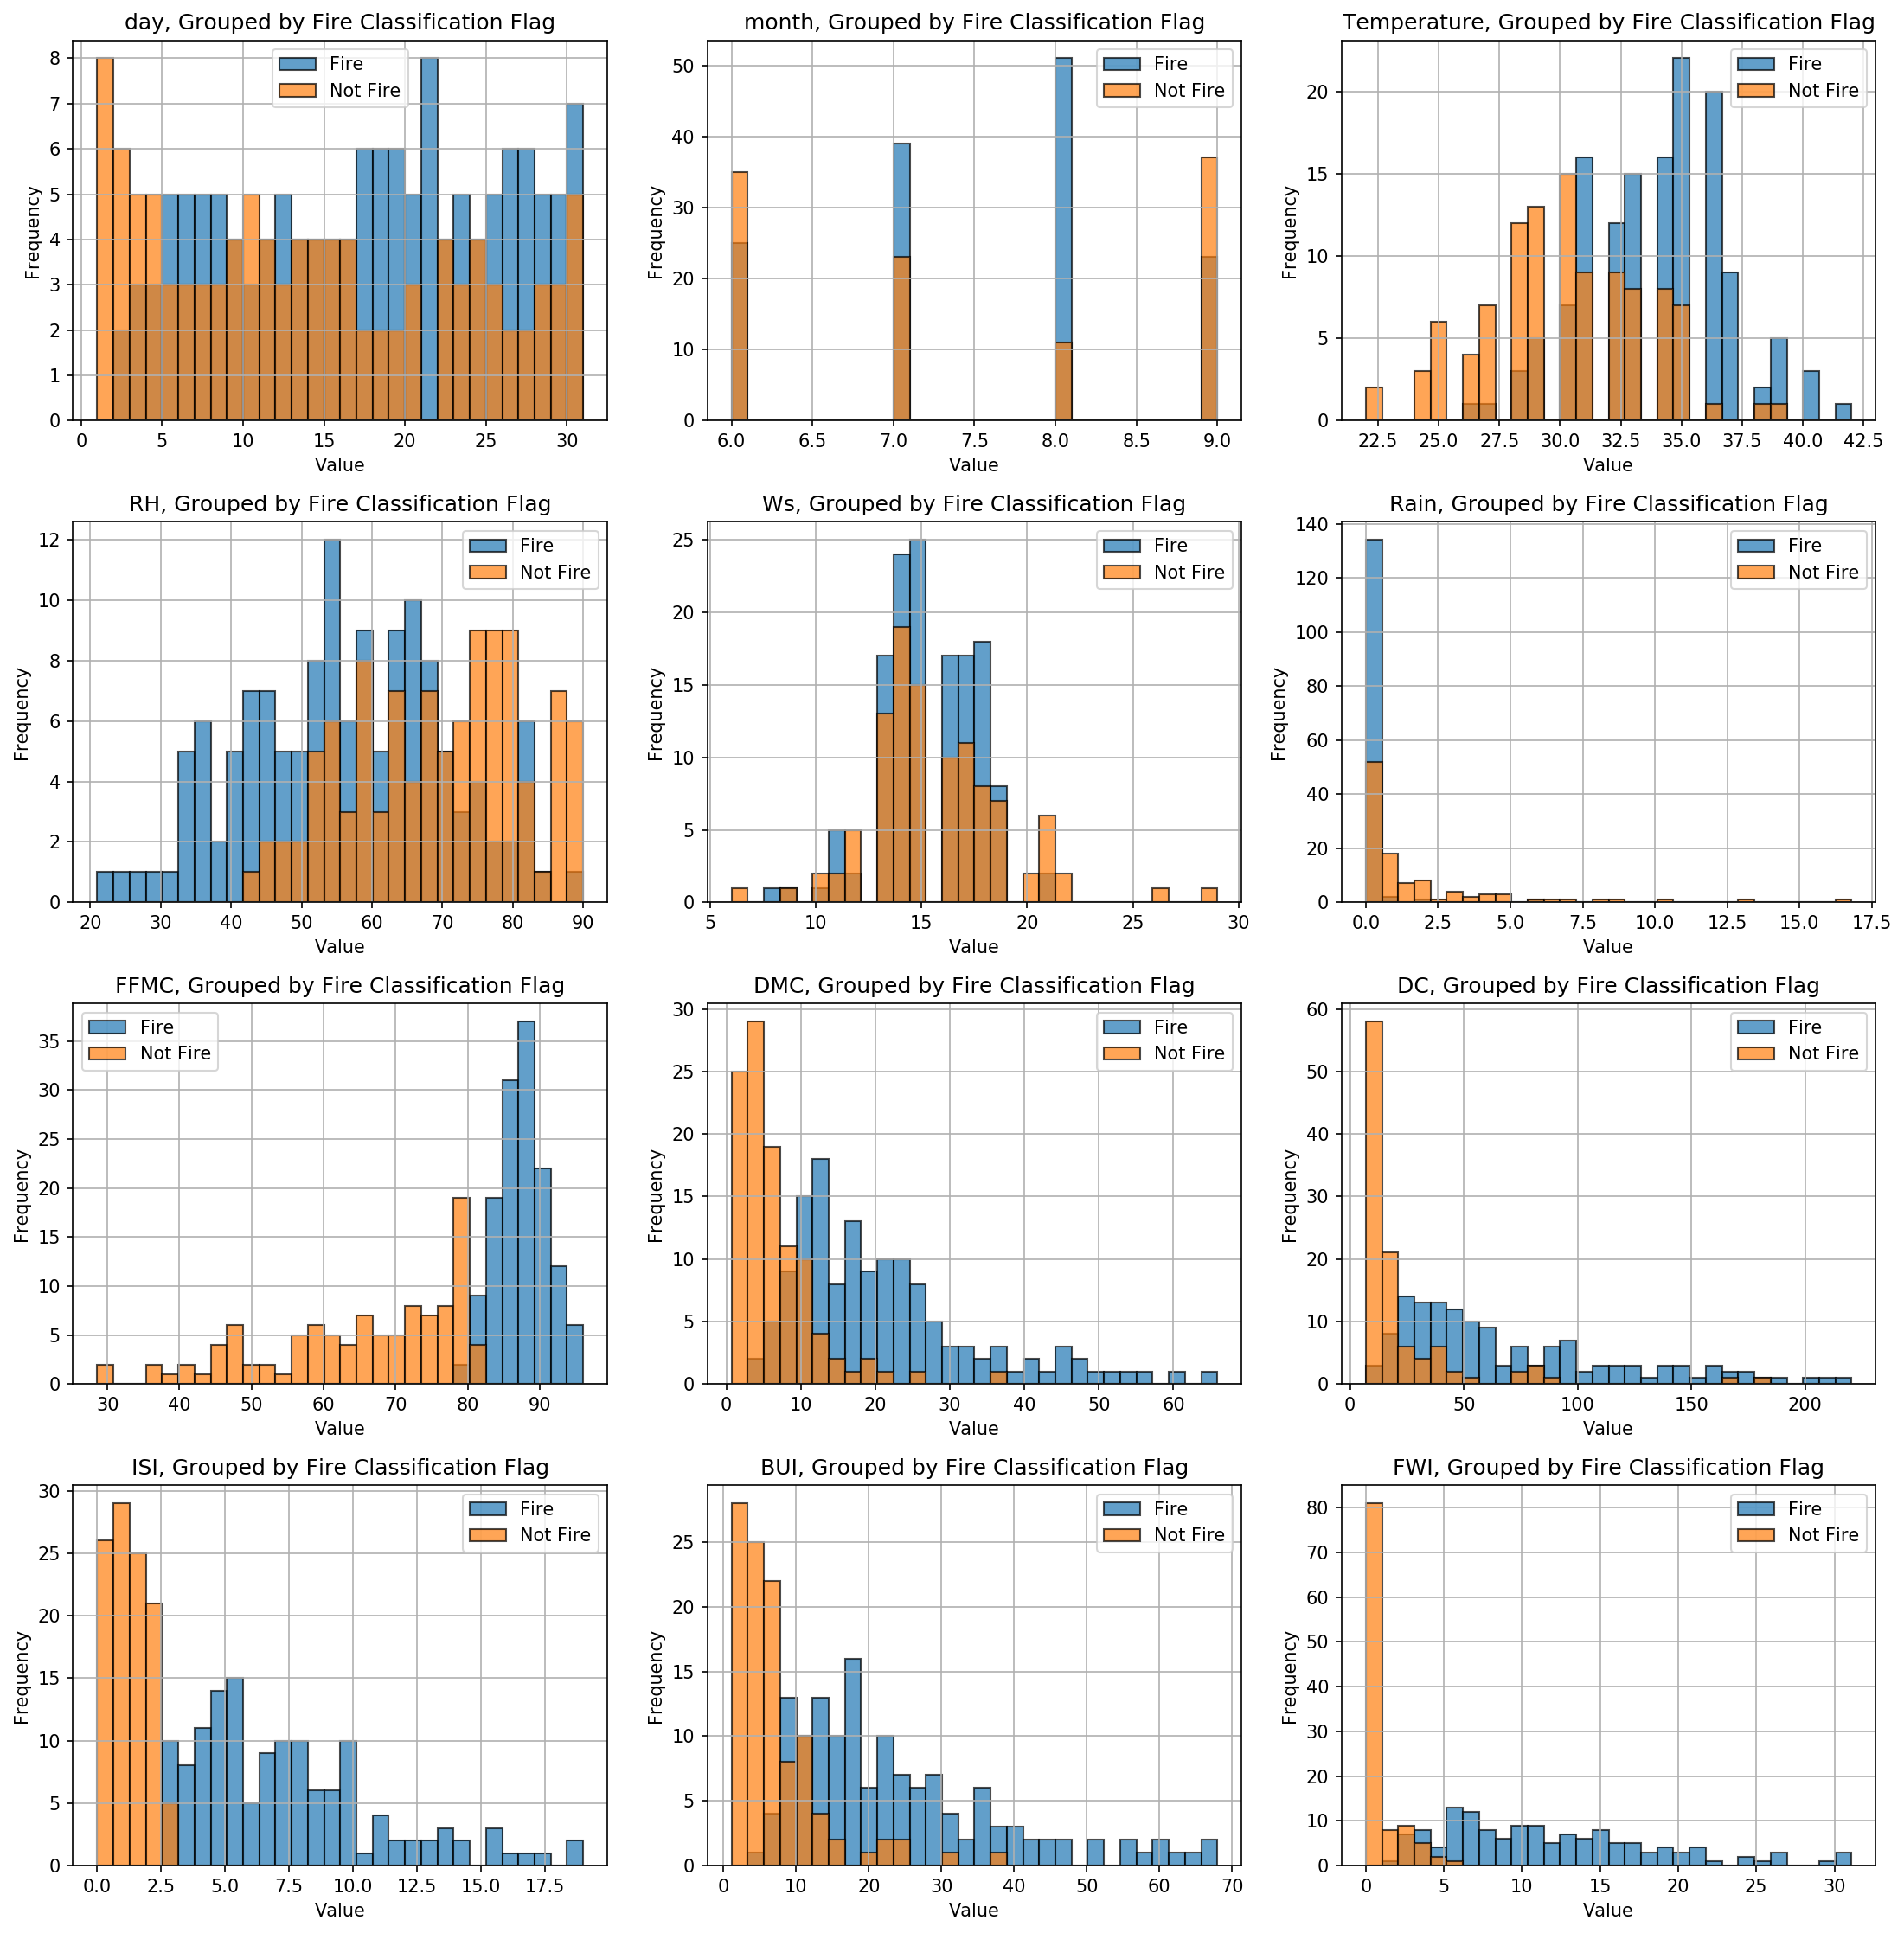

In [107]:

class_df = fire_df.groupby('Classes')
fire_true_df = class_df.get_group('fire')
fire_false_df = class_df.get_group('not fire')

cols = ['day','month','Temperature','RH','Ws','Rain','FFMC','DMC','DC','ISI','BUI','FWI']
count=0

fig, ax = plt.subplots(4,3,figsize=(15,15),dpi=150)
for i,col in enumerate(ax):
    for j, row in enumerate(col):
        #col = 'Temperature'
        """
        print("Flagged Fires:")
        print(f"FWI Median = {np.median(fire_true_df[col])}")
        print(f"FWI Standard Deviation = {np.std(fire_true_df[col])}")

        print("Not Fires:")
        print(f"FWI Median = {np.median(fire_false_df[col])}")
        print(f"FWI Standard Deviation = {np.std(fire_false_df[col])}")
        """

        bins=np.histogram(np.hstack((fire_true_df[cols[count]],fire_false_df[cols[count]])), bins=30)[1] #get the bin edges

        ax[i,j].hist(fire_true_df[cols[count]],bins,ec='k',alpha=0.7,label='Fire')
        ax[i,j].hist(fire_false_df[cols[count]],bins,ec='k',alpha=0.7,label='Not Fire')

        ax[i,j].set_title(f'{cols[count]}, Grouped by Fire Classification Flag')
        ax[i,j].grid()
        ax[i,j].legend()
        ax[i,j].set_xlabel('Value')
        ax[i,j].set_ylabel('Frequency')
        count+=1
plt.tight_layout()

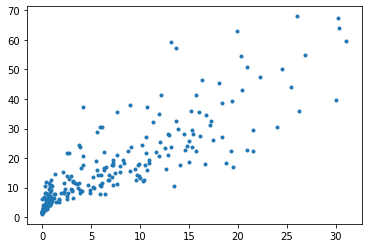

In [83]:
plt.plot(fire_df['FWI'],fire_df['BUI'],'.')

### Data Preprocessing